## FACE DETECTION WITH HISTOGRAM-OF-ORIENTED-GRADIENTS

[**Histogram of Oriented Gradients**](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html) (`HOG`) algorithm is used to extract features from human faces which are fed as _positive_ examples into a classifier for face detection.  

The process that we need to follow to extract the features from the images using HOG is:
- Preprocess the images (resize operation).
- With the use of **8x8** patch we calculate the gradients, magnituds and histogram of the images.
- Combining 4 pathches (**16x16**), we apply L2 Normalization to them.
- The normalized histograms are then concatenated to form the features to be fed into the classifier.


# Dataset

To train the classifier we need two types of examples, 1) Positive examples which are images of faces where we going to extract features that the classfier will _"learn"_, and 2) Negative examples which are non-face images used as the _"false"_ class. Both type of images will form our dataset.

For the positive images the [`Labeled Faces in the Wild`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) dataset included in Scikit-Learn is used (**10,000 images**) and to create our negative images several categories of images from [Scikit-Image](https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html) are used (**3,000 images**).

A total of `13,000` images are used to create our dataset.


In [1]:
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.datasets import fetch_lfw_people
from skimage import data, feature, transform
from itertools import chain
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def save_images(path, data):
    '''
    Save images' vector representation
    into Numpy binary format
    '''
    np.save(path, data)

## Positive Samples

In [8]:
# Load a dataset of human faces (positive samples)
faces = fetch_lfw_people()
positive = faces.images[:10000]

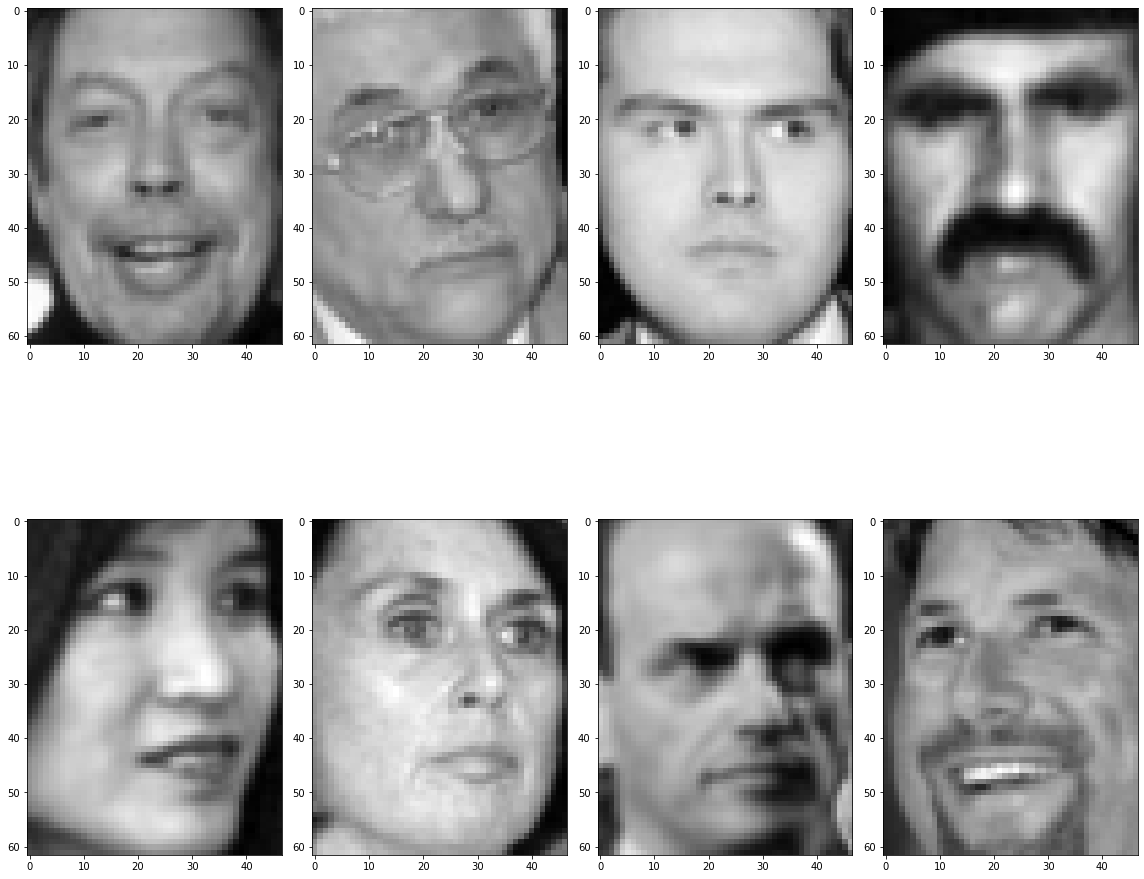

In [4]:
# Getting a sample from positive images
fig, ax = plt.subplots(2,4, figsize=(16, 16))
row = [0,1,2,3] * 2
for i in range(8):
    if i < 4:
        ax[0,row[i]].imshow(positive[i], cmap="gray")
    else:
        ax[1,row[i]].imshow(positive[i], cmap="gray")

fig.tight_layout()
plt.show()

## Negative Samples

To retreive the image scikit-image provides a function that we need to call to get the image.  
Due to the number of images are limited we need to generate new variants from the base images using `PathcExtractor`.

In [5]:
# Load base images to create negative samples
topics = ['coins', 'text', 'grass', 'gravel', 'horse', 'page']
base_images = [(getattr(data, name)()) for name in topics]

In [6]:
# Using PatchExtractor to generate new variants from base images
def generate_random_variants(image, num_images=500, patch_size=(62, 47)):
    extractor = PatchExtractor(patch_size=patch_size, max_patches=num_images, random_state=42)
    patches = extractor.transform((image[np.newaxis]))
    
    return patches

In [7]:
# 3000 samples without a human face (negative samples)
negative = np.vstack([generate_random_variants(image) for image in base_images])

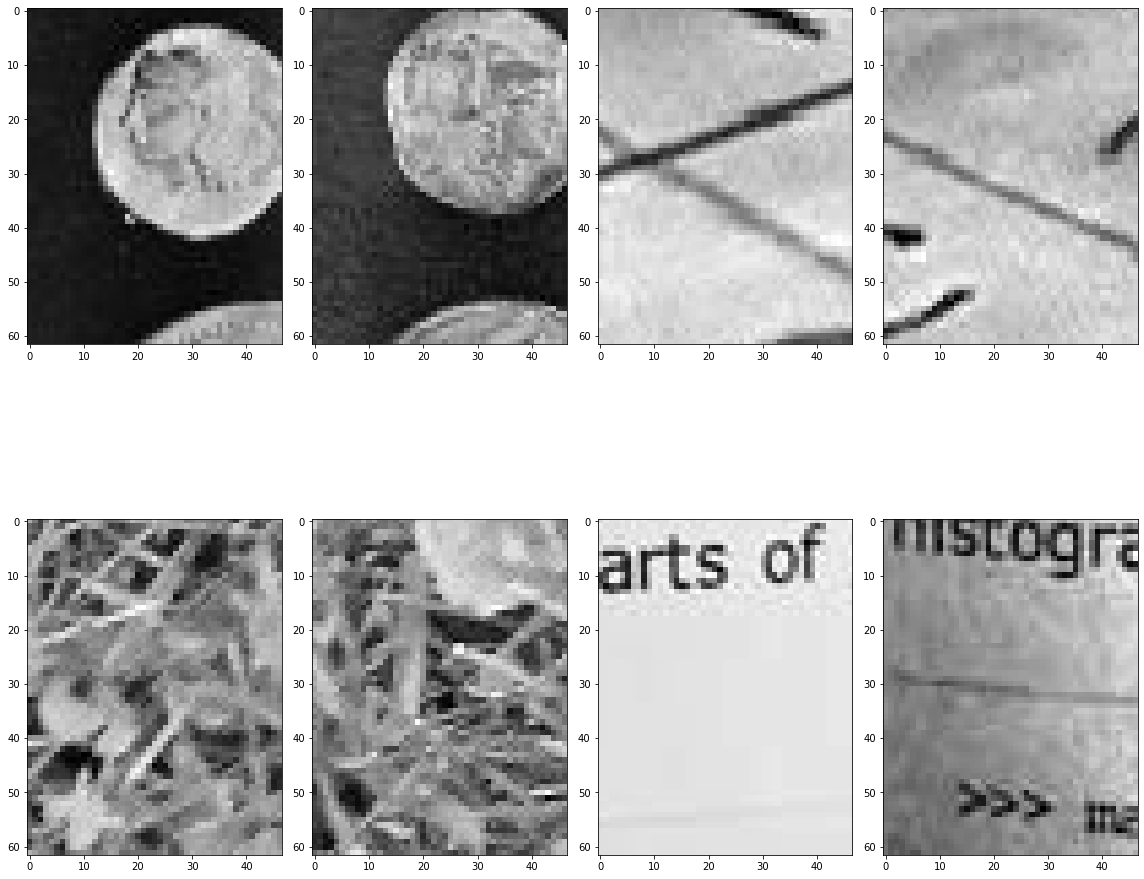

In [8]:
# Getting a sample from negative images
fig, ax = plt.subplots(2,4, figsize=(16, 16))
row = [0,1,2,3] * 2
for i in range(8):
    if i < 2:
        ax[0,row[i]].imshow(negative[i], cmap="gray")
    elif i < 4:
        ax[0,row[i]].imshow(negative[i+500], cmap="gray")
    elif i < 6:
        ax[1,row[i]].imshow(negative[i+1000], cmap="gray")
    else:
        ax[1,row[i]].imshow(negative[i+2500], cmap="gray")

fig.tight_layout()
plt.show()

In [9]:
# saving images' dataset
images_data = np.array([image for image in chain(positive, negative)])
save_images('face_detection_images.npy', images_data)

## Training Dataset

Once we have our positive and negative images we combine them in a single dataset that we use to train the classifier.  
**Notice that for each image, histogram of oriented gradients is applied**

For the lables, we select two classes:
- `class 1`, which is positive for human face.
- `class 0`, which is negative for human face.

In [10]:
# NB: HOG transformation is a time consuming task
X_train = np.array([feature.hog(image) for image in chain(positive, negative)])

In [11]:
# array for all images
y_train = np.zeros(X_train.shape[0])
# setting label for class 1
y_train[:positive.shape[0]] = 1

In [12]:
# Saving training dataset (with HOG transformation applied)
save_images('xtrain_dataset.npy', X_train)
save_images('labels_dataset.npy', y_train)

## SVM Classifier

For our face detection classifier, a Linear Support Vector Machine is used.  
Then, the classifier is trained with the images were HOG was applied.

In [2]:
X_train = np.load('./Data/Train/xtrain_dataset.npy')
y_train = np.load('./Data/Train/labels_dataset.npy')

In [3]:
from sklearn.svm import LinearSVC

In [4]:
svm = LinearSVC()

In [5]:
# Learning process based on the training dataset
svm.fit(X_train, y_train)

LinearSVC()

## Testing the complete pipeline

To test our classifier two images are used, one _positive_ image and one _negative_ image.  
To do the test we need to run the complete pipeline, namely we need:
- Resize the image
- Compute HOG for the image
- Feed image into clssifier to do the prediction

In [6]:
from skimage.io import imread

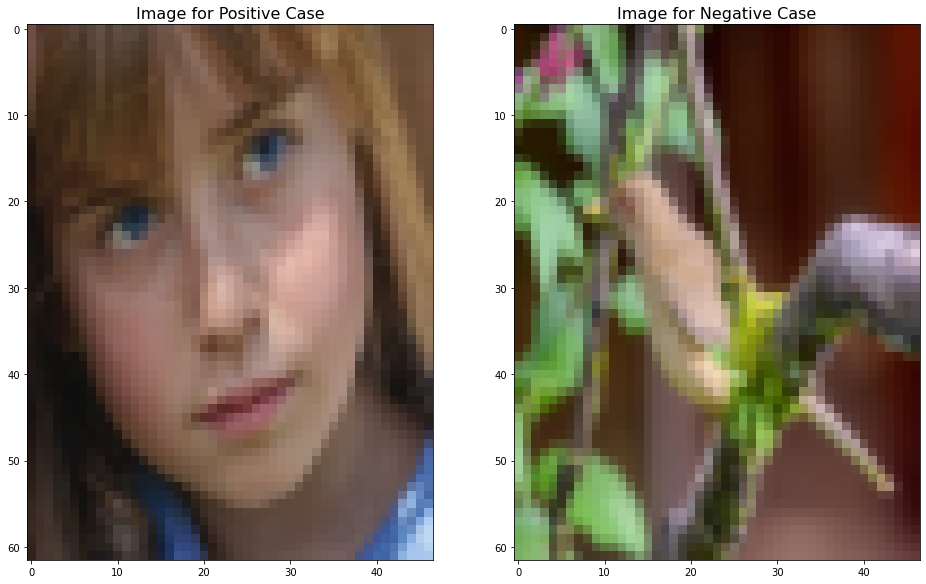

In [9]:
test_positive = imread(fname='./Data/Test/girl_face.png')
test_positive = transform.resize(test_positive, positive[0].shape)
test_negative = imread(fname='./Data/Test/bird.jpg')
test_negative = transform.resize(test_negative, positive[0].shape)

fig, ax = plt.subplots(1,2, figsize=(16, 16))
ax[0].imshow(test_positive)
ax[0].set_title("Image for Positive Case", fontsize=16)
ax[1].imshow(test_negative)
ax[1].set_title("Image for Negative Case", fontsize=16)
plt.show()

In [10]:
# Prediction for test_positive image
test_positive_hog = np.array([feature.hog(test_positive)])
prediction = svm.predict(test_positive_hog)
print("Prediction made by SVM: %f" % prediction)

Prediction made by SVM: 1.000000


In [11]:
# Prediction for test_positive image
test_negative_hog = np.array([feature.hog(test_negative)])
prediction = svm.predict(test_negative_hog)
print("Prediction made by SVM: %f" % prediction)

Prediction made by SVM: 0.000000


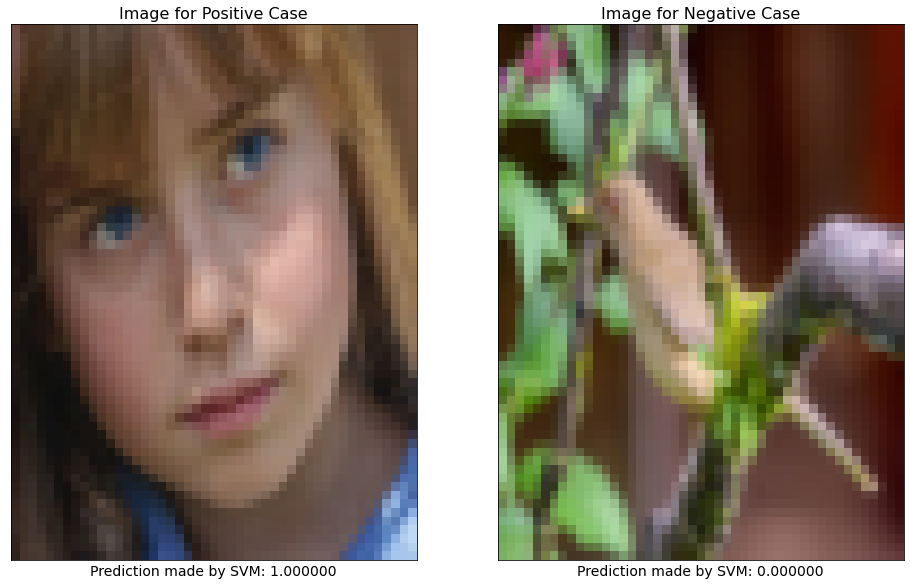

In [15]:
fig, ax = plt.subplots(1,2, figsize=(16, 16), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(test_positive)
ax[0].set_title("Image for Positive Case", fontsize=16)
ax[0].set_xlabel('Prediction made by SVM: 1.000000', fontsize=14)
ax[1].imshow(test_negative)
ax[1].set_title("Image for Negative Case", fontsize=16)
ax[1].set_xlabel('Prediction made by SVM: 0.000000', fontsize=14)
plt.show()